In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print("The target (0~16):\n", train_y[0:16])

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
The target (0~16):
 [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


# **Data Preparation**

In [3]:
# array flatten and transpose
x_train = train_X.reshape(60000,784).T
x_test = test_X.reshape(10000,784).T

# Normalization
x_train = x_train / 255
x_test = x_test / 255

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
#print(train_X[29999, :, :])
#print(x_train[200:500, 29999])

# one-hot encoding for y_train and y_test
y_train_one_hot = np.zeros((10, 60000))
for i in range(len(train_y)):
    y_train_one_hot[train_y[i], i] = 1

y_test_one_hot = np.zeros((10, 10000))
for i in range(len(test_y)):
    y_test_one_hot[test_y[i], i] = 1

x_train: (784, 60000)
x_test: (784, 10000)


# **Activation Function**

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derive(x):
    return x > 0

def sigmoid (x):  # for the hidden layer
    return np.exp(-np.logaddexp(0, -x))  # 對於值非常大的輸入有穩定的輸出
    # return 1 / (1 + np.exp(-x))  # 標準版本

def sigmoid_derive (x):  #微分後
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):  # for the output layer
    expon_x = np.exp(x)
    exponsum = np.sum(expon_x, axis=0, keepdims=True)  # 沿著row(垂直)做加總
    sofmax_x = expon_x / (exponsum + 1e-8)
    return sofmax_x

def tanh(x):
    return np.tanh(x)

def tanh_derive(x):
    return 1 - tanh(x) ** 2

def cross_entropy_loss(x, y):
    m = x.shape[0]
    loss = -np.sum(x * np.log(y + 1e-8)) / m  # 加1e-8是為了防止y為0，loss變無限大(inf)
    return loss

# **CASE.1** <p>
*The number of neurons in hidden layer:* `10`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `60000(all)`<p>
*Learning algorithm:* `fixed(0.1)`<p>

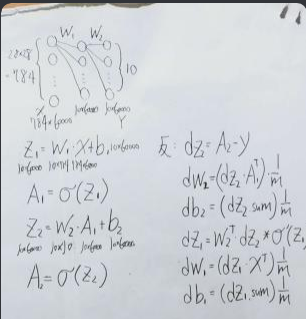

In [ ]:
class NeuronNet_sigmoid:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

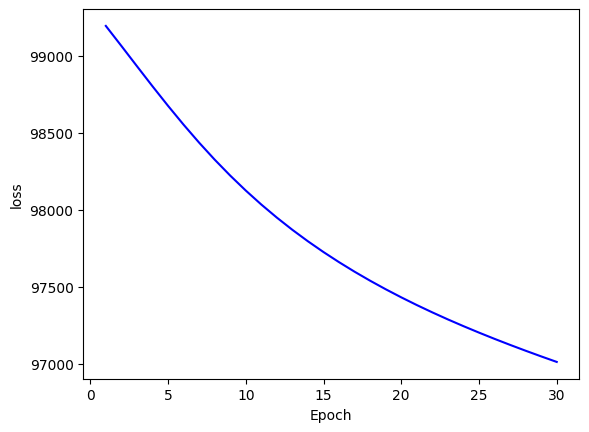

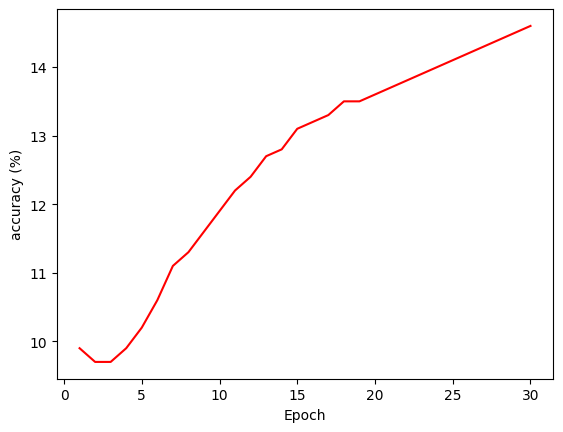

Test set accuracy:14.83%


In [ ]:
# train
nn1 = NeuronNet_sigmoid(10, 10, 30, 60000, 0.1)
nn1.train()
nn1.predict_test(x_test)

# **CASE.2** <p>
*The number of neurons in hidden layer:* `10`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `1000`<p>
*Learning algorithm:* `fixed(0.1)`<p>

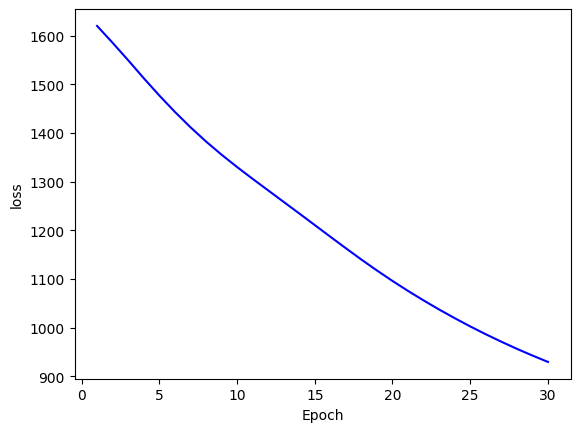

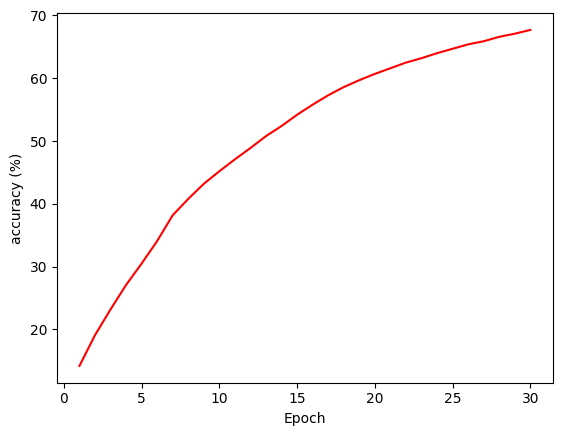

Test set accuracy:68.41%


In [ ]:
nn2 = NeuronNet_sigmoid(10, 10, 30, 1000, 0.1)
nn2.train()
nn2.predict_test(x_test)

# **CASE.3** <p>
*The number of neurons in hidden layer:* `10`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `fixed(0.1)`<p>

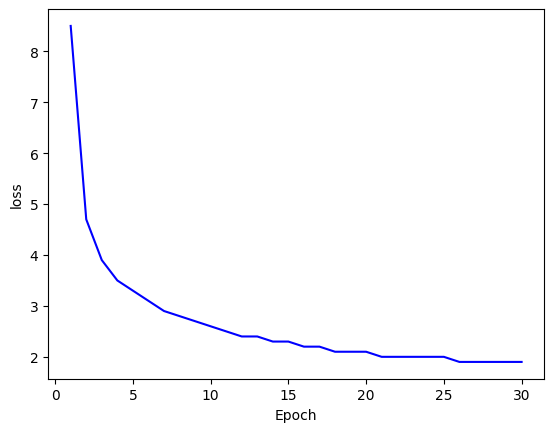

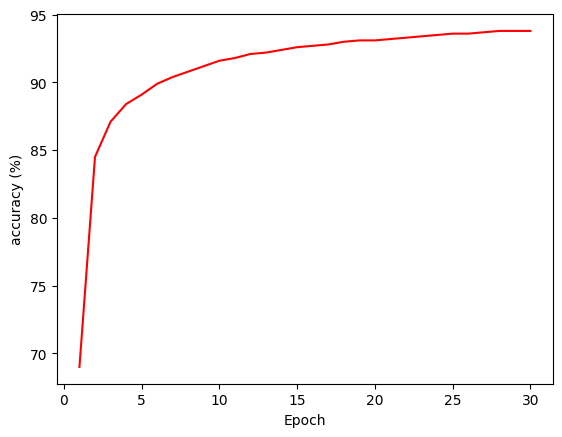

Test set accuracy:92.48%


In [ ]:
nn3 = NeuronNet_sigmoid(10, 10, 30, 10, 0.1)
nn3.train()
nn3.predict_test(x_test)

# **CASE.4** <p>
*The number of neurons in hidden layer:* `20`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `fixed(0.1)`<p>

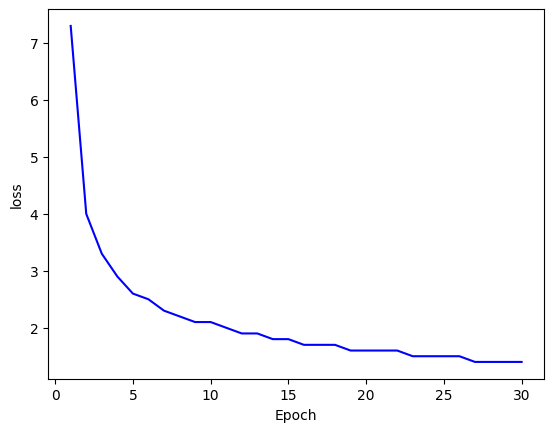

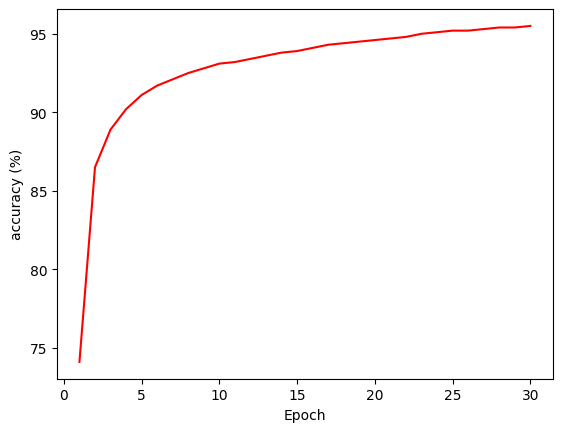

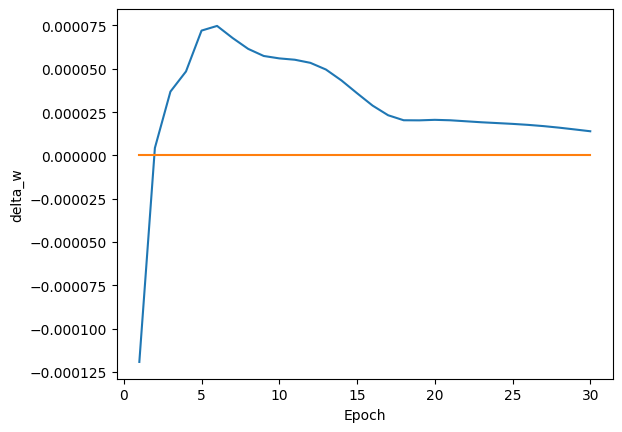

Test set accuracy:93.59%


In [ ]:
nn4 = NeuronNet_sigmoid(10, 20, 30, 10, 0.1, True)
nn4.train()
nn4.predict_test(x_test)

# **CASE.5** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `fixed(0.1)`<p>

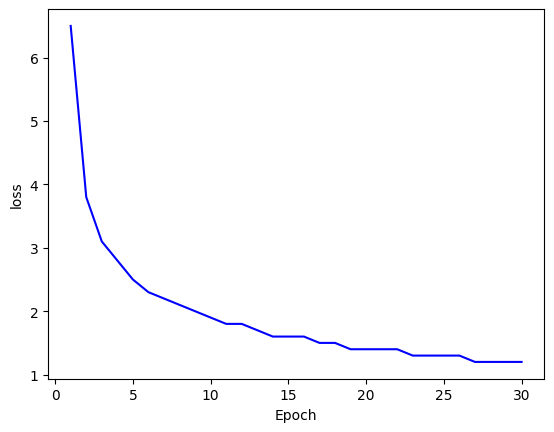

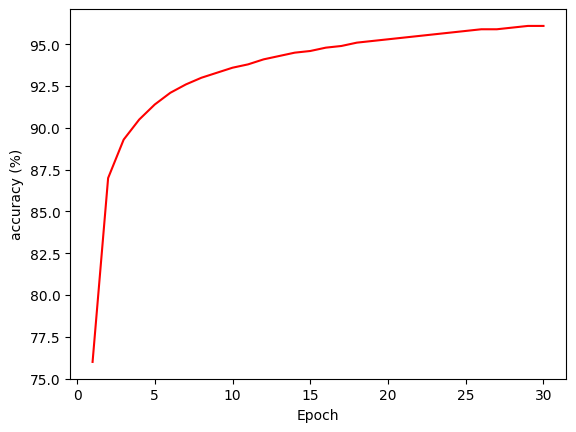

Test set accuracy:94.14%


In [ ]:
nn5 = NeuronNet_sigmoid(10, 30, 30, 10, 0.1)
nn5.train()
nn5.predict_test(x_test)

# **CASE.6** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `ReLU`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `fixed(0.1)`<p>

In [ ]:
class NeuronNet_ReLU:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = relu(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * relu_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

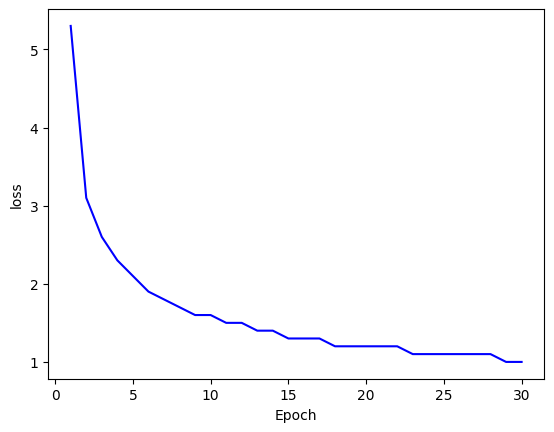

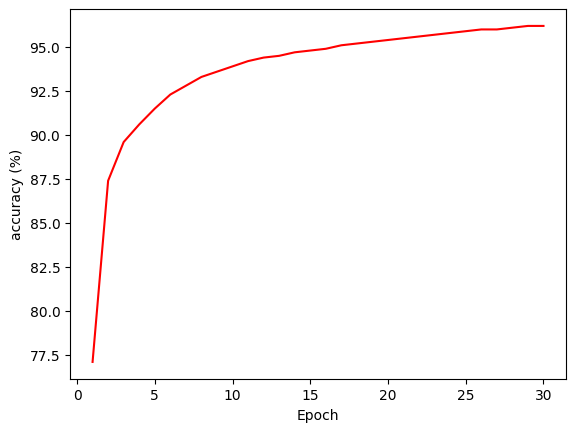

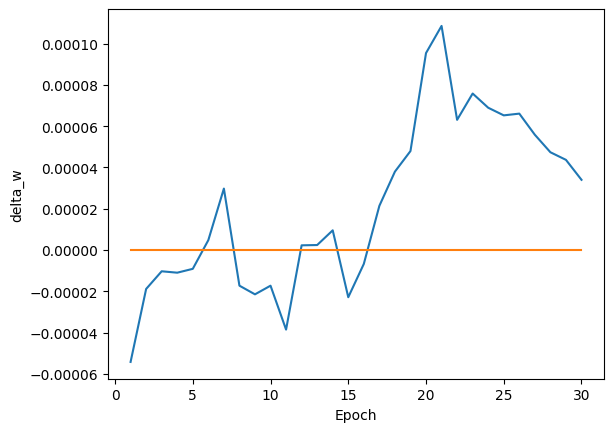

Test set accuracy:94.29%


In [ ]:
nn6 = NeuronNet_ReLU(10, 30, 30, 10, 0.1, True)
nn6.train()
nn6.predict_test(x_test)

# **CASE.7** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `tanh`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `fixed(0.1)`<p>

In [ ]:
class NeuronNet_Tanh:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = tanh(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * tanh_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias
        self.w1 = self.w1 - self.learning_rate * self.dw1
        self.b1 = self.b1 - self.learning_rate * self.db1
        self.w2 = self.w2 - self.learning_rate * self.dw2
        self.b2 = self.b2 - self.learning_rate * self.db2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

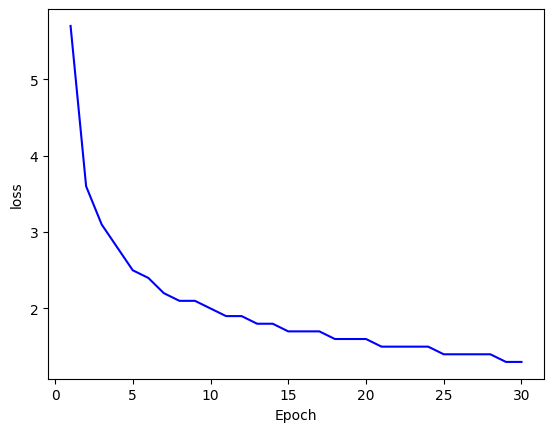

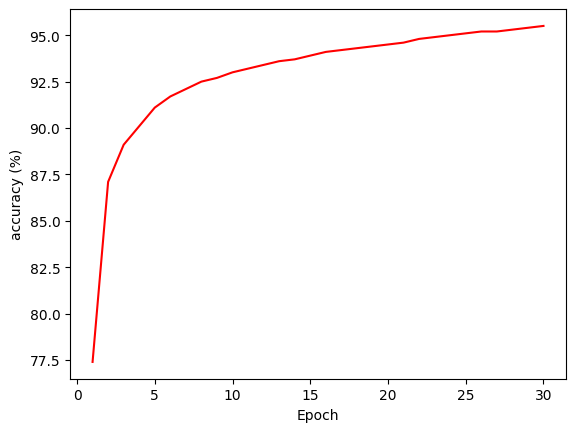

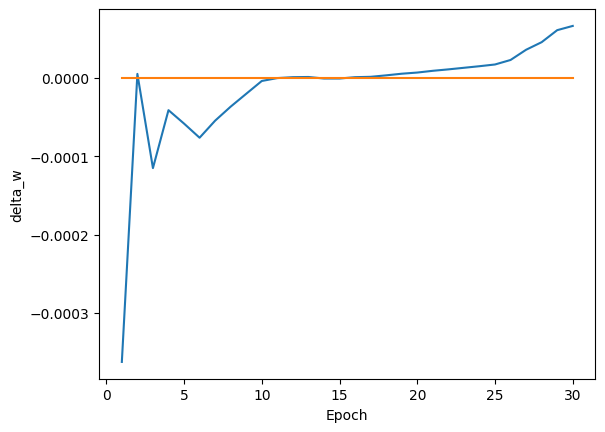

Test set accuracy:93.25%


In [ ]:
nn7 = NeuronNet_Tanh(10, 30, 30, 10, 0.1, True)
nn7.train()
nn7.predict_test(x_test)

# **CASE.8** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `SGDM(belta=0.3)`<p>

In [ ]:
class NeuronNet_sigmoid_SGDM:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, SGDM_belta=0.1, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        self.SGDM_belta = SGDM_belta
        self.SGDM_mt_w1 = 0
        self.SGDM_mt_w2 = 0
        self.SGDM_mt_b1 = 0
        self.SGDM_mt_b2 = 0

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias (SGDM)
        self.SGDM_mt_w1 = self.SGDM_belta * self.SGDM_mt_w1 + (1 - self.SGDM_belta) * self.dw1
        self.SGDM_mt_b1 = self.SGDM_belta * self.SGDM_mt_b1 + (1 - self.SGDM_belta) * self.db1
        self.SGDM_mt_w2 = self.SGDM_belta * self.SGDM_mt_w2 + (1 - self.SGDM_belta) * self.dw2
        self.SGDM_mt_b2 = self.SGDM_belta * self.SGDM_mt_b2 + (1 - self.SGDM_belta) * self.db2
        self.w1 = self.w1 - self.learning_rate * self.SGDM_mt_w1
        self.b1 = self.b1 - self.learning_rate * self.SGDM_mt_b1
        self.w2 = self.w2 - self.learning_rate * self.SGDM_mt_w2
        self.b2 = self.b2 - self.learning_rate * self.SGDM_mt_b2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

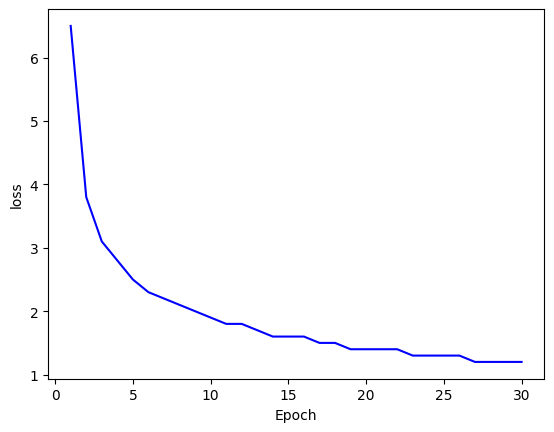

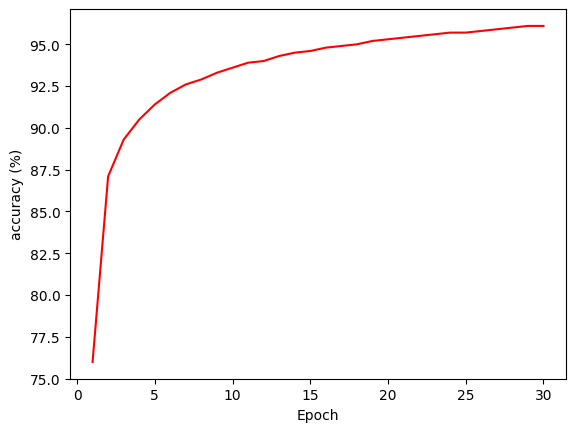

Test set accuracy:94.03%


In [ ]:
nn8 = NeuronNet_sigmoid_SGDM(10, 30, 30, 10, 0.1, 0.3)
nn8.train()
nn8.predict_test(x_test)

# **CASE.9** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `Adagrad`<p>

In [ ]:
class NeuronNet_sigmoid_Adagrad:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        # Initialize variables for Adagrad
        self.accumulated_gradient_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.accumulated_gradient_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.accumulated_gradient_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.accumulated_gradient_b2 = np.zeros((num_class, 1))

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias (Adagrad)
        self.accumulated_gradient_w1 += self.dw1 ** 2
        self.accumulated_gradient_b1 += self.db1 ** 2
        self.accumulated_gradient_w2 += self.dw2 ** 2
        self.accumulated_gradient_b2 += self.db2 ** 2

        # Calculate updates with Adagrad
        self.w1 = self.w1 - self.learning_rate * self.dw1 / (np.sqrt(self.accumulated_gradient_w1) + 1e-8)
        self.b1 = self.b1 - self.learning_rate * self.db1 / (np.sqrt(self.accumulated_gradient_b1) + 1e-8)
        self.w2 = self.w2 - self.learning_rate * self.dw2 / (np.sqrt(self.accumulated_gradient_w2) + 1e-8)
        self.b2 = self.b2 - self.learning_rate * self.db2 / (np.sqrt(self.accumulated_gradient_b2) + 1e-8)


    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0
            self.gradient_count = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

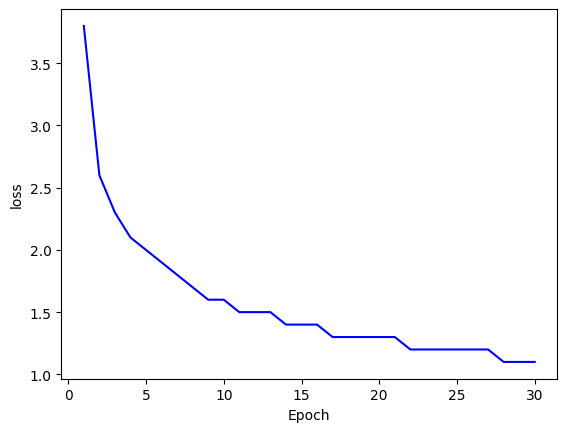

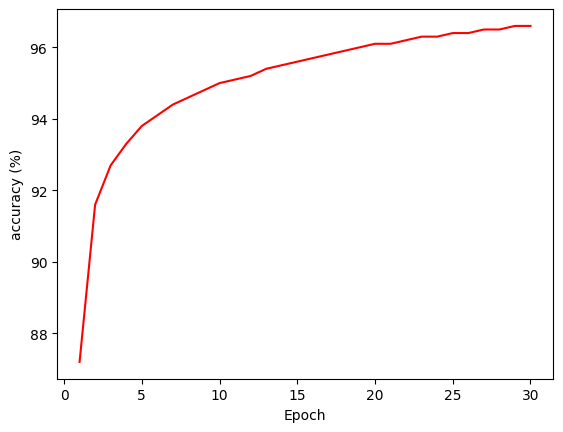

Test set accuracy:94.73%


In [ ]:
nn9 = NeuronNet_sigmoid_Adagrad(10, 30, 30, 10, 0.1)
nn9.train()
nn9.predict_test(x_test)

# **CASE.10** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `RMSProp(belta=0.3)`<p>

In [ ]:
class NeuronNet_sigmoid_RMSProp:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, RMSProp_belta=0.1, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        self.RMSProp_belta = RMSProp_belta
        self.accumulated_gradient_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.accumulated_gradient_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.accumulated_gradient_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.accumulated_gradient_b2 = np.zeros((num_class, 1))

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias (RMSProp)
        self.accumulated_gradient_w1 = (self.RMSProp_belta * self.accumulated_gradient_w1) + ((1 - self.RMSProp_belta) * self.dw1 ** 2)
        self.accumulated_gradient_b1 = (self.RMSProp_belta * self.accumulated_gradient_b1) + ((1 - self.RMSProp_belta) * self.db1 ** 2)
        self.accumulated_gradient_w2 = (self.RMSProp_belta * self.accumulated_gradient_w2) + ((1 - self.RMSProp_belta) * self.dw2 ** 2)
        self.accumulated_gradient_b2 = (self.RMSProp_belta * self.accumulated_gradient_b2) + ((1 - self.RMSProp_belta) * self.db2 ** 2)

        # Calculate updates with RMSProp
        epsilon = 1e-8  # Small value to prevent division by zero
        self.w1 -= (self.learning_rate * self.dw1) / (np.sqrt(self.accumulated_gradient_w1) + epsilon)
        self.b1 -= (self.learning_rate * self.db1) / (np.sqrt(self.accumulated_gradient_b1) + epsilon)
        self.w2 -= (self.learning_rate * self.dw2) / (np.sqrt(self.accumulated_gradient_w2) + epsilon)
        self.b2 -= (self.learning_rate * self.db2) / (np.sqrt(self.accumulated_gradient_b2) + epsilon)

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

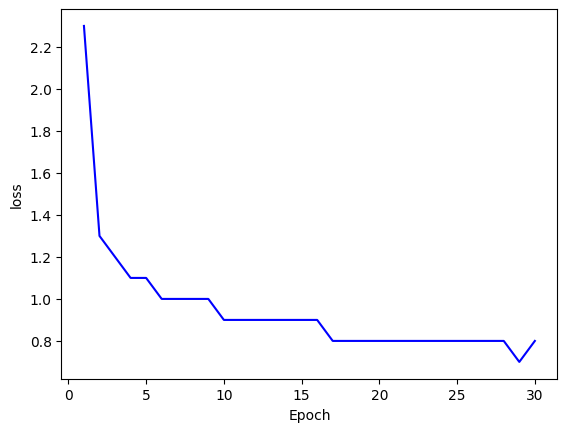

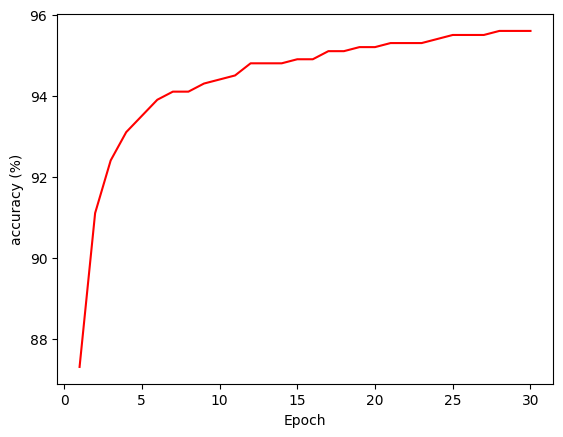

Test set accuracy:94.71%


In [ ]:
nn10 = NeuronNet_sigmoid_RMSProp(10, 30, 30, 10, 0.1, 0.3)
nn10.train()
nn10.predict_test(x_test)

# **CASE.11** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `Adam`<p>

In [ ]:
class NeuronNet_sigmoid_Adam:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        # Initialize variables for Adam
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.v_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.m_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.v_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.m_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.v_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.m_b2 = np.zeros((num_class, 1))
        self.v_b2 = np.zeros((num_class, 1))
        self.t = 0  # Time step counter for Adam

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        # Update moments for Adam
        self.t += 1
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.dw1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.dw1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.db1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.db1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.dw2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.dw2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.db2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.db2 ** 2)

        # Bias correction for moments
        m_w1_hat = self.m_w1 / (1 - self.beta1 ** self.t)
        v_w1_hat = self.v_w1 / (1 - self.beta2 ** self.t)
        m_b1_hat = self.m_b1 / (1 - self.beta1 ** self.t)
        v_b1_hat = self.v_b1 / (1 - self.beta2 ** self.t)
        m_w2_hat = self.m_w2 / (1 - self.beta1 ** self.t)
        v_w2_hat = self.v_w2 / (1 - self.beta2 ** self.t)
        m_b2_hat = self.m_b2 / (1 - self.beta1 ** self.t)
        v_b2_hat = self.v_b2 / (1 - self.beta2 ** self.t)

        # Calculate updates with Adam
        self.w1 -= self.learning_rate * m_w1_hat / (np.sqrt(v_w1_hat) + self.epsilon)
        self.b1 -= self.learning_rate * m_b1_hat / (np.sqrt(v_b1_hat) + self.epsilon)
        self.w2 -= self.learning_rate * m_w2_hat / (np.sqrt(v_w2_hat) + self.epsilon)
        self.b2 -= self.learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + self.epsilon)

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0
            self.t = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

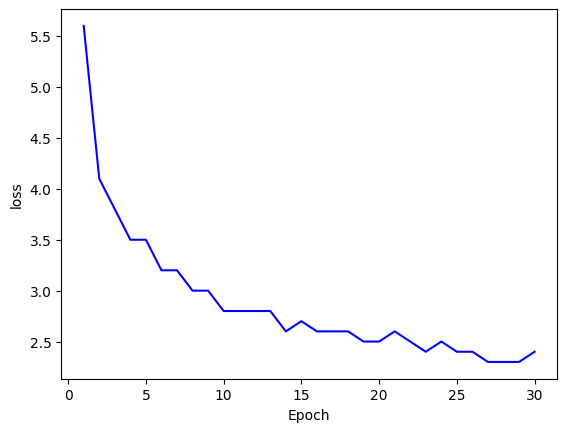

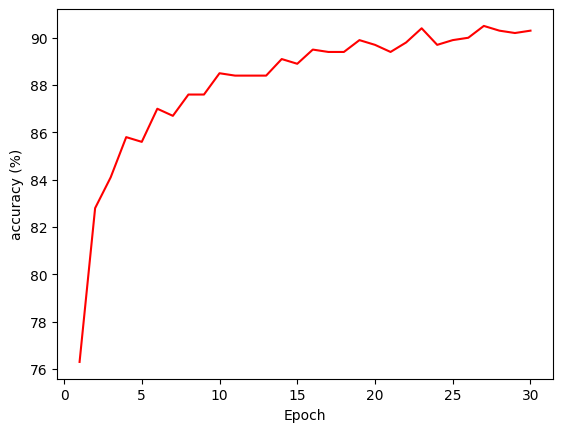

Test set accuracy:88.64%


In [ ]:
nn11 = NeuronNet_sigmoid_Adam(10, 30, 30, 10, 0.1)
nn11.train()
nn11.predict_test(x_test)

可以看出Adam算法有些不穩定，而且需要修改為穩定的sigmoid函數才能正常訓練。

# **CASE.12** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `weight decay--SGDWM(gamma=0.00001)`<p>

In [5]:
class NeuronNet_sigmoid_SGDWM:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, SGDWM_lamda=0.1, gamma=0.00001, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        self.SGDWM_lamda = SGDWM_lamda
        self.SGDM_mt_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.SGDM_mt_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.SGDM_mt_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.SGDM_mt_b2 = np.zeros((num_class, 1))
        self.gamma = gamma

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        #update weights and bias (SGDM)
        self.SGDM_mt_w1 = self.SGDWM_lamda * self.SGDM_mt_w1 + self.learning_rate * self.dw1
        self.SGDM_mt_b1 = self.SGDWM_lamda * self.SGDM_mt_b1 + self.learning_rate * self.db1
        self.SGDM_mt_w2 = self.SGDWM_lamda * self.SGDM_mt_w2 + self.learning_rate * self.dw2
        self.SGDM_mt_b2 = self.SGDWM_lamda * self.SGDM_mt_b2 + self.learning_rate * self.db2
        self.w1 = self.w1 - self.SGDM_mt_w1 - self.gamma * self.w1
        self.b1 = self.b1 - self.SGDM_mt_b1 - self.gamma * self.b1
        self.w2 = self.w2 - self.SGDM_mt_w2 - self.gamma * self.w2
        self.b2 = self.b2 - self.SGDM_mt_b2 - self.gamma * self.b2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

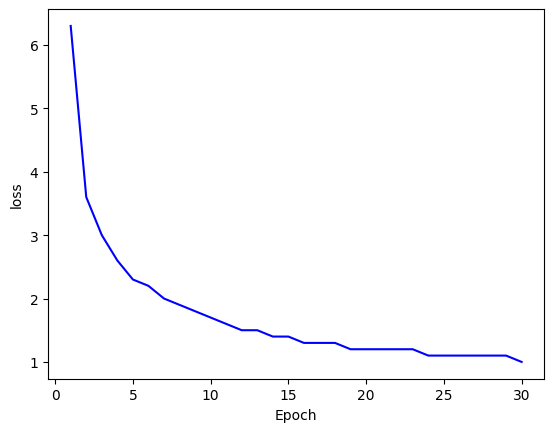

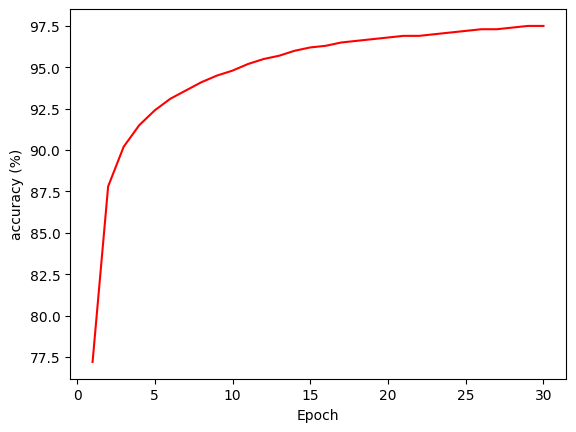

Test set accuracy:96.42%


In [ ]:
nn12 = NeuronNet_sigmoid_SGDWM(10, 30, 30, 10, 0.1)
nn12.train()
nn12.predict_test(x_test)

我gamma從0.1開始調，weights當然是完全訓練不起來，因為mt剛吃到梯度資訊，而又扣掉0.1*前一次的weights，把應該更新的量都扣掉。後來gamma調至0.00001後在測試資料集上有最佳的準確率。

# **CASE.13** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `weight decay--AdamW(gamma=0.0001)`<p>

In [ ]:
class NeuronNet_sigmoid_AdamW:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, beta1=0.9, beta2=0.999, gamma=0.0001, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(2)
        self.b1 = np.random.randn(num_hiddenlayer_neuron, 1)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        np.random.seed(4)
        self.b2 = np.random.randn(num_class, 1)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        # Initialize variables for Adam
        self.beta1 = beta1
        self.beta2 = beta2
        self.m_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.v_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.m_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.v_b1 = np.zeros((num_hiddenlayer_neuron, 1))
        self.m_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.v_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.m_b2 = np.zeros((num_class, 1))
        self.v_b2 = np.zeros((num_class, 1))
        self.t = 0  # Time step counter for Adam
        self.gamma = gamma

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input) + self.b1
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1) + self.b2
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True) / self.batch_size

        # Update moments for Adam
        self.t += 1
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.dw1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.dw1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.db1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.db1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.dw2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.dw2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.db2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.db2 ** 2)

        # Bias correction for moments
        m_w1_hat = self.m_w1 / (1 - self.beta1 ** self.t)
        v_w1_hat = self.v_w1 / (1 - self.beta2 ** self.t)
        m_b1_hat = self.m_b1 / (1 - self.beta1 ** self.t)
        v_b1_hat = self.v_b1 / (1 - self.beta2 ** self.t)
        m_w2_hat = self.m_w2 / (1 - self.beta1 ** self.t)
        v_w2_hat = self.v_w2 / (1 - self.beta2 ** self.t)
        m_b2_hat = self.m_b2 / (1 - self.beta1 ** self.t)
        v_b2_hat = self.v_b2 / (1 - self.beta2 ** self.t)

        # Calculate updates with Adam
        self.w1 = self.w1 - self.learning_rate * (m_w1_hat / (np.sqrt(v_w1_hat) + 1e-8) - self.gamma * self.w1)
        self.b1 = self.b1 - self.learning_rate * (m_b1_hat / (np.sqrt(v_b1_hat) + 1e-8) - self.gamma * self.b1)
        self.w2 = self.w2 - self.learning_rate * (m_w2_hat / (np.sqrt(v_w2_hat) + 1e-8) - self.gamma * self.w2)
        self.b2 = self.b2 - self.learning_rate * (m_b2_hat / (np.sqrt(v_b2_hat) + 1e-8) - self.gamma * self.b2)

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0
            self.t = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

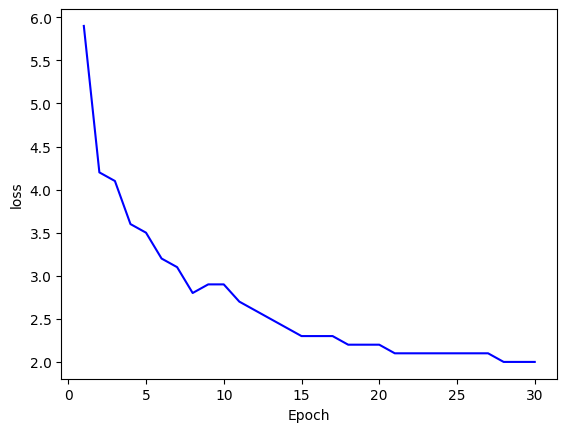

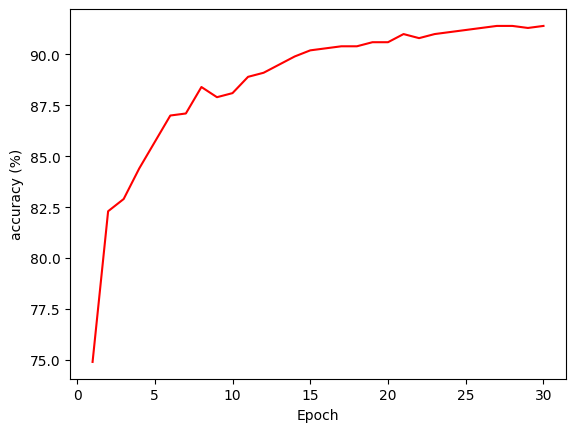

Test set accuracy:90.2%


In [ ]:
nn13 = NeuronNet_sigmoid_AdamW(10, 30, 30, 10, 0.1)
nn13.train()
nn13.predict_test(x_test)

# **結論：**<p>
1.在`sigmoid`、`ReLU`、`tanh`這三個不同的activation function的訓練結果中，在測試資料集上的準確度相差不大(1%內)。<p>
2.在batch size的調整中，在經過相同Epoch下，batch size值越小，準確率越高，提升越快，最佳的值為10。<p>
4.在調整隱藏層神經元數量10、20、30中，訓練準確率有上升的趨勢，只是20和30的準確率差距不大，因此推論在神經元數量再加大也是不會有多大效益，因此採用30個神經元數量。<p>
5.在`fixed`、`SGDM`、`Adagrad`、`RMSProp`、`Adam`的算法中，除了`Adam`較不穩定以外，測試集準確度差別都不太大。<p>
6.後來加入weight decay項，讓整體準確率提升一些。<p>
7.最佳測試集準確率：**CASE.12** -- **96.42%**


# **額外測試：**

# **CASE.14** <p>
*The number of neurons in hidden layer:* `100`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `weight decay--SGDWM(gamma=0.00001)`<p>

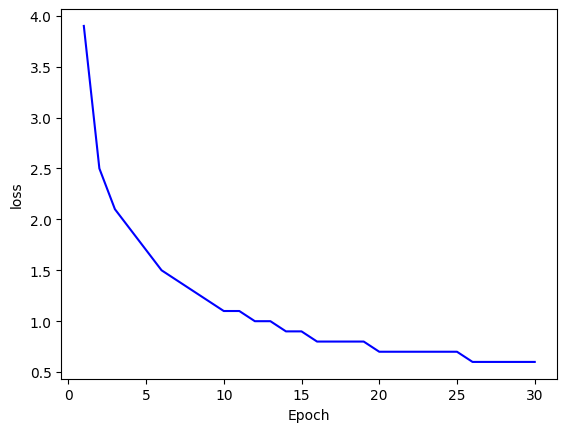

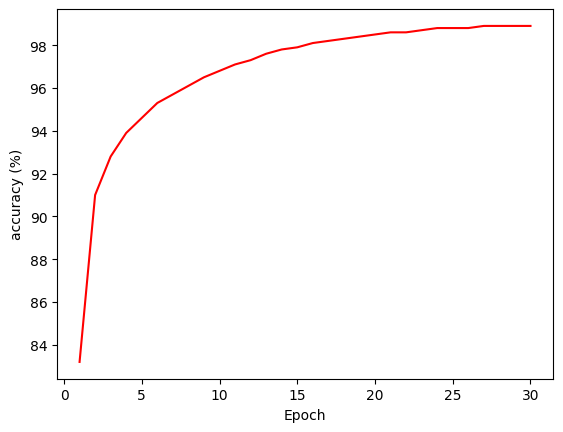

Test set accuracy:97.51%


In [6]:
nn14 = NeuronNet_sigmoid_SGDWM(10, 100, 30, 10, 0.1)
nn14.train()
nn14.predict_test(x_test)

隱藏層100個神經元訓練時間大約5分鐘，大約是訓練隱藏層30個神經元的時間的2.5倍，然而測試集準確率卻只提升1.09%，不太划算。

# **CASE.15** <p>
*The number of neurons in hidden layer:* `30`<p>
*Activation function:* `sigmoid`<p>
*Batch size:* `10`<p>
*Learning algorithm:* `weight decay--SGDWM(gamma=0.00001)`<p>
Bias removed

In [7]:
class NeuronNet_sigmoid_SGDWM_Nobias:
    def __init__(self, num_class, num_hiddenlayer_neuron, epochs, batch_size, learning_rate, SGDWM_lamda=0.1, gamma=0.00001, delta_w_plot=False):
        np.random.seed(1)
        self.w1 = np.random.randn(num_hiddenlayer_neuron, 784)
        np.random.seed(3)
        self.w2 = np.random.randn(num_class, num_hiddenlayer_neuron)
        self.batch_size = batch_size
        self.batch_counts = int(60000 / batch_size)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_loss_sum = 0
        self.batch_accuracy_sum = 0
        self.Loss_for_Plot = np.zeros(epochs)
        self.Accuracy_for_Plot = np.zeros(epochs)
        self.delta_w_plot = delta_w_plot
        self.delta_w1_averge = 0
        self.delta_w2_averge = 0
        self.delta_w1_for_Plot = np.zeros(epochs)
        self.delta_w2_for_Plot = np.zeros(epochs)
        self.SGDWM_lamda = SGDWM_lamda
        self.SGDM_mt_w1 = np.zeros((num_hiddenlayer_neuron, 784))
        self.SGDM_mt_w2 = np.zeros((num_class, num_hiddenlayer_neuron))
        self.gamma = gamma

    def forward(self, input):
        self.input = input
        self.z1 = np.dot(self.w1, self.input)
        self.A1 = sigmoid(self.z1)
        self.z2 = np.dot(self.w2, self.A1)
        self.A2 = softmax(self.z2)
        return self.A2

    def backward(self, predict, ground_truth):
        dz2 = predict - ground_truth
        self.dw2 = np.dot(dz2, self.A1.T) / self.batch_size
        self.dz1 = np.dot(self.w2.T, dz2) * sigmoid_derive(self.z1)
        self.dw1 = np.dot(self.dz1, self.input.T) / self.batch_size

        #update weights and bias (SGDM)
        self.SGDM_mt_w1 = self.SGDWM_lamda * self.SGDM_mt_w1 + self.learning_rate * self.dw1
        self.SGDM_mt_w2 = self.SGDWM_lamda * self.SGDM_mt_w2 + self.learning_rate * self.dw2
        self.w1 = self.w1 - self.SGDM_mt_w1 - self.gamma * self.w1
        self.w2 = self.w2 - self.SGDM_mt_w2 - self.gamma * self.w2

    def save_loss_accuracy(self, predict, ground_truth, start, end):
        self.batch_loss_sum += cross_entropy_loss(predict, ground_truth)

        # calculate accuracy
        correct_count = 0
        y_predict = np.argmax(predict, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(self.batch_size):
            if (y_predict[column] == train_y[column + start]):
                correct_count += 1

        self.accuracy = round(correct_count / self.batch_size * 100, 2)
        self.batch_accuracy_sum += self.accuracy

    def save_data_for_plot(self, index):
        self.Loss_for_Plot[index] = round(self.batch_loss_sum / self.batch_counts, 1)
        self.Accuracy_for_Plot[index] = round(self.batch_accuracy_sum / self.batch_counts, 1)

        # save delta_w
        if self.delta_w_plot:
            self.delta_w1_averge = np.mean(self.dw1)
            self.delta_w2_averge = np.mean(self.dw2)
            self.delta_w1_for_Plot[index] = self.delta_w1_averge
            self.delta_w2_for_Plot[index] = self.delta_w2_averge

    def show_accuracy_loss(self, showtext=False):
        self.epochs_for_plot = np.arange(1, self.epochs+1, dtype=int)

        if showtext:
            print("Accuracy:{}%".format(self.Accuracy_for_Plot[-1]))
            print("Loss:{}".format(self.Loss_for_Plot[-1]))

        else:
            # show the loss graph
            plt.plot(self.epochs_for_plot, self.Loss_for_Plot, color='blue')
            plt.xlabel("Epoch")
            plt.ylabel("loss")
            plt.show()

            # show the accuracy graph
            plt.plot(self.epochs_for_plot, self.Accuracy_for_Plot, color='red')
            plt.xlabel("Epoch")
            plt.ylabel("accuracy (%)")
            plt.show()

        if self.delta_w_plot:
            # show the delta_w graph
            plt.plot(self.epochs_for_plot, self.delta_w1_for_Plot, self.epochs_for_plot, self.delta_w2_for_Plot)
            plt.xlabel("Epoch")
            plt.ylabel("delta_w")
            plt.show()

    def train(self):
        for epoch in range(self.epochs):
            for batch_count in range(self.batch_counts):
                start = batch_count * self.batch_size
                end = start + self.batch_size
                self.output = self.forward(x_train[:, start:end])
                self.backward(self.output, y_train_one_hot[:, start:end])
                self.save_loss_accuracy(self.output, y_train_one_hot[:, start:end], start, end)

            self.save_data_for_plot(epoch)
            self.batch_loss_sum = 0
            self.batch_accuracy_sum = 0

        self.show_accuracy_loss()

    def predict_test(self, input):
        self.predict_result = self.forward(input)

        # calculate accuracy
        test_correct_count = 0
        y_predict_test = np.argmax(self.predict_result, axis=0).T  # (10, 60000) matrix => watch along with column => y_predict:(60000, 1)
        for column in range(len(test_y)):
            if (y_predict_test[column] == test_y[column]):
                test_correct_count += 1

        self.test_accuracy = round(test_correct_count / len(test_y) * 100, 2)
        print("Test set accuracy:{}%".format(self.test_accuracy))

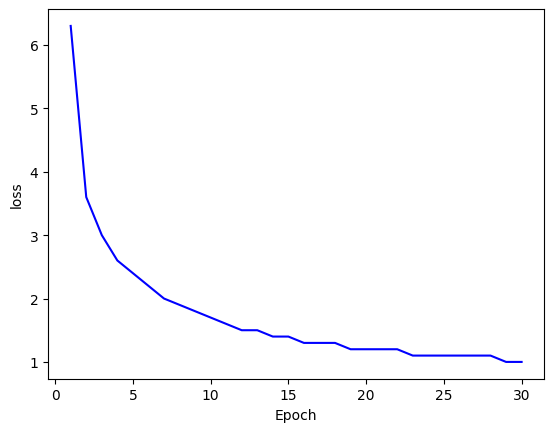

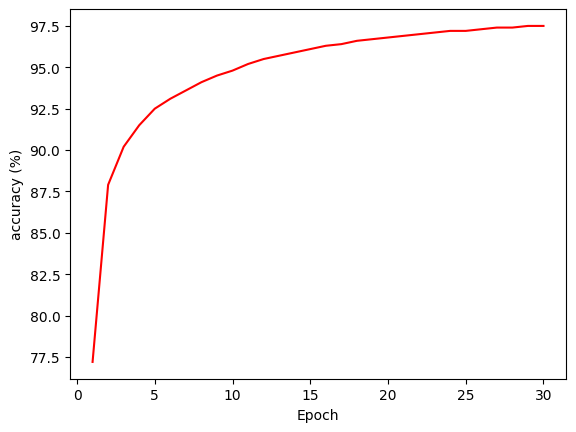

Test set accuracy:96.25%


In [8]:
nn15 = NeuronNet_sigmoid_SGDWM_Nobias(10, 30, 30, 10, 0.1)
nn15.train()
nn15.predict_test(x_test)

去除與保留bias對訓練資料與測試資料的準確率結果相差不大(96.25% vs 96.42%)。